<a href="https://colab.research.google.com/github/Nomi230/ColabWork/blob/main/Denoising_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
!pip install noisereduce
!pip install PyWavelets
!pip install soundfile

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

import librosa
import soundfile

import pickle

import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cpu


### **Audio Files**

In [ ]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))
audio3 = data

In [ ]:
audio, samplerate = librosa.load('/content/WhatsApp Audio 2022-04-30 at 11.47.09 PM.mpeg',sr=8000)
audio1, samplerate1 = librosa.load('134717-0-0-12.wav',sr=8000)
audio2, samplerate2 = librosa.load('/content/WhatsApp Audio 2022-04-30 at 11.47.09 PM.mpeg')
audio1, samplerate1 = librosa.load('134717-0-0-12.wav')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


### **CNN**

In [ ]:
def pytorch_tensor(x):
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [ ]:
class Conv_encoder(nn.Module):
    def __init__(self):
        super(Conv_encoder, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [ ]:
#alternative: speech:
batch=1
# audio, samplerate = librosa.load("audio_ACDC - Back In Black Intro.wav", mono=False, sr=None, offset=6)
audio=audio2+audio1[:len(audio2)]
print(audio)
#convert1=np.ndarray.flatten(third_signal)
audio[0:]/=np.abs(audio[0:]).max()
audio[1:]/=np.abs(audio[1:]).max()
X_train=pytorch_tensor(audio[0:]).to(device) #Convert to pytorch format, batch is first dimension    
X_test=pytorch_tensor(audio[1:]).to(device) #Convert to pytorch format, batch is first dimension   

[0.0597936  0.0825339  0.06662937 ... 0.00528671 0.03014293 0.04941278]


In [ ]:
print("Generate Model:")
model = Conv_encoder().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
print(loss_fn)
#loss_fn = nn.L1Loss()
Ypred=model(X_train)
   
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X_train[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())

Generate Model:
Total number of parameters: 131105
Def. loss function:
outputlen= 69634
Input X.shape= torch.Size([1, 1, 70384])
Target Y.shape= torch.Size([1, 1, 69634])
Target Y= tensor([[[0.1275, 0.1760, 0.1421,  ..., 0.1343, 0.1184, 0.1098]]])
Y.type()= torch.FloatTensor


In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";
    
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
Ypred=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False
    
if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(10000):
        Ypred=model(X_train)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
"""
torch.save({#'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, "audio_autoenc.torch")
"""
    
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

#Test on training set:
predictions=model(X_train).cpu() # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=np.array(predictions)
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,6))
for b in range(batch):
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()
xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)

In [ ]:
import IPython.display as ipd
display(ipd.Audio(xrek, rate=samplerate));

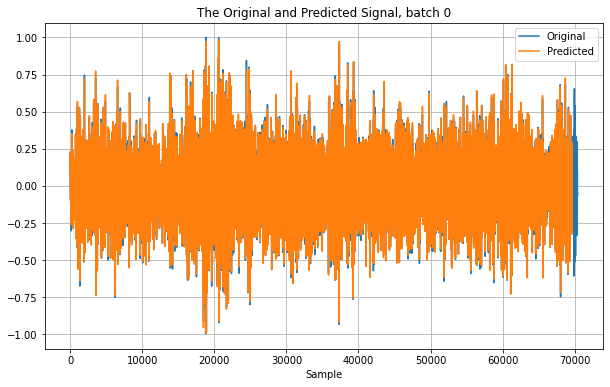

In [ ]:
#Test on Verification set:
predictions=model(X_test).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
plt.figure(figsize=(10,6))
for b in range(batch):
    plt.plot(np.array(X_test[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()
xrek=predictions[:,0,:]

In [ ]:
#Test on shifted input:
X_train_shifted_100 = nn.ConstantPad1d(100, 0)(X_train)
predictions=model(X_train_shifted_100).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
print(predictions)
xrek=predictions[:,0,:]

In [ ]:
display(ipd.Audio(xrek, rate=samplerate));

### **With Sationary Noise**

In [ ]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(audio3), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = audio3+noise
samplerate=rate

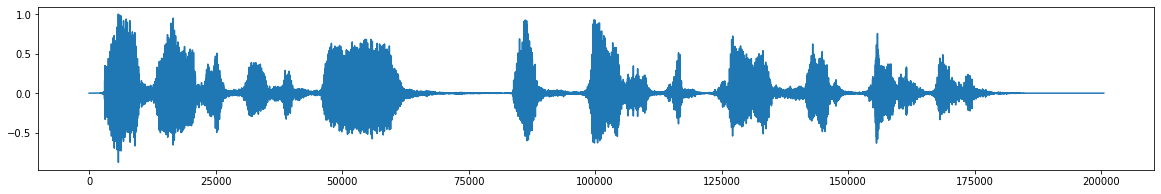

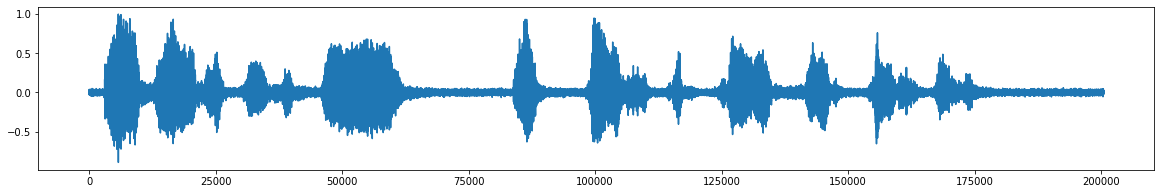

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio3)
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [ ]:
IPython.display.Audio(data=audio3, rate=samplerate)

In [ ]:
IPython.display.Audio(data=audio_clip_band_limited, rate=samplerate)

### **Spectral Gating**

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=samplerate, n_std_thresh_stationary=1.5,stationary=True)

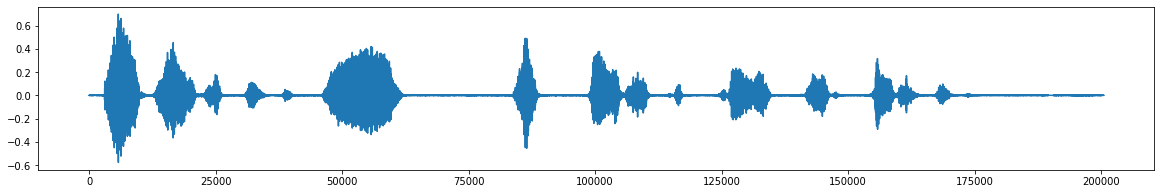

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=samplerate)

### **Wavelet**

In [ ]:
x_denoise = denoise_wavelet(audio_clip_band_limited, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='False')

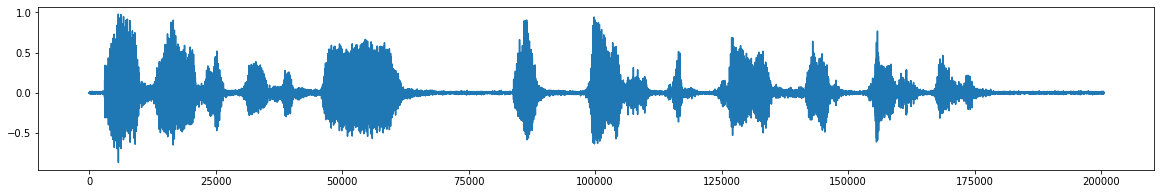

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(x_denoise)d

In [ ]:
IPython.display.Audio(data=x_denoise, rate=samplerate)

**With Non-Stationary Sound**

In [ ]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
response = urllib.request.urlopen(url)
noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

In [ ]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

In [ ]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip = audio3 + noise_clip

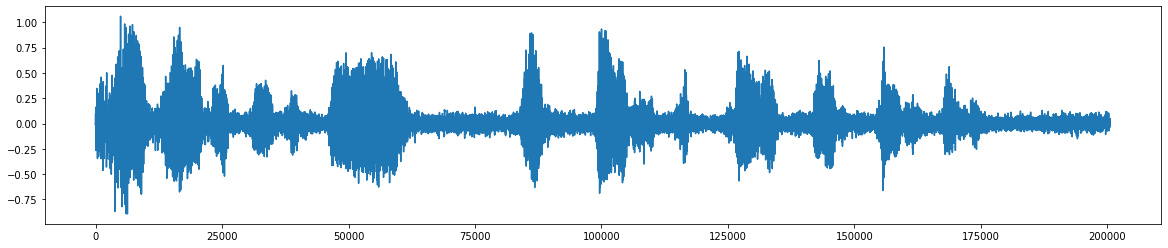

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip)
IPython.display.Audio(data=audio_clip, rate=noise_rate)

### **Spectral Gating**

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

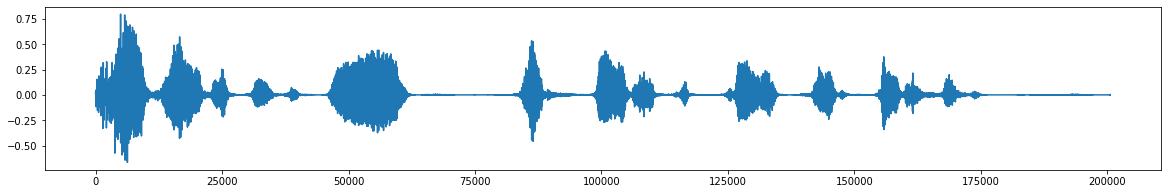

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=samplerate)

### **Wavelet**

In [ ]:
x_denoise = denoise_wavelet(audio_clip, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='False')

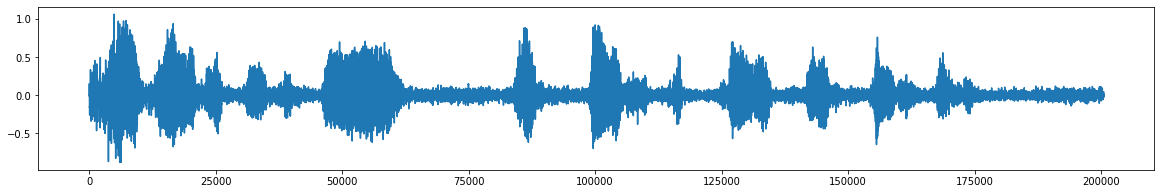

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(x_denoise)

In [ ]:
IPython.display.Audio(data=x_denoise, rate=samplerate)